# Some simple tricks for building Hamiltonians of arbitrarily shaped 2D systems

In [1]:
%pylab inline
#plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


In [2]:
# these are modules to deal with sparse matrices
import scipy.sparse as ss
import scipy.sparse.linalg as sl

In [3]:
# widges for sliders galore
from ipywidgets import *

In [4]:
L=20 # define rectangular sample 
W=30
y,x=meshgrid(range(W),range(L))
x=x.flatten() # generate coordinates
y=y.flatten()

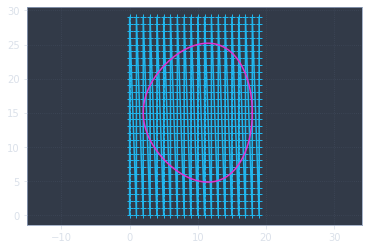

In [5]:
t=linspace(0,2*pi,314)
plot(x,y,'+-') 
# come up with the shape of the potato
px=8*L/20*cos(t)+L/2
py=10*W/30*sin(t)+sin(2*t)+W/2
plot(px,py)
axis('equal');
#plt.axes().set_aspect('equal')


In [6]:
# define Path object which can be used to check if points are inside
krumpli=mpl.path.Path(array([px,py]).T)
# find indeces that are in the potato
benne_van=krumpli.contains_points(list(map(lambda i:(i[0],i[1]),array([x,y]).T)))
# take inverse if you want
#benne_van=~benne_van # uncomment this line if you want the inverse of the shape

(-0.9500000000000001, 19.95, -1.4500000000000002, 30.45)

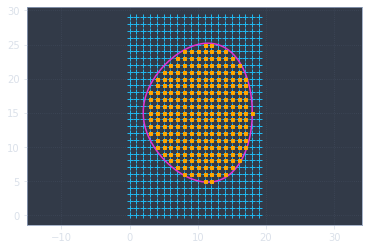

In [7]:
# look at who is inside and who is outside of the potato
plot(x,y,'+')
plot(px,py)
plot(x[benne_van],y[benne_van],'s',ms=3)
axis('equal')


In [8]:
# define some helper matrices to be used in hamiltonian construction
idL=ss.eye(L)
idW=ss.eye(W)

odL=ss.diags(ones(L-1),1,(L,L))
odW=ss.diags(ones(W-1),1,(W,W))

In [9]:
# define slices of the hamiltonian
h0=-odW-odW.T
h1=-idW

In [10]:
# build hamiltonian corresponding to big square
H=(ss.kron(idL,h0)+ss.kron(odL,h1)+ss.kron(odL,h1).T)

In [11]:
# cut region of interest
Hbenne=H[:,benne_van][benne_van,:]

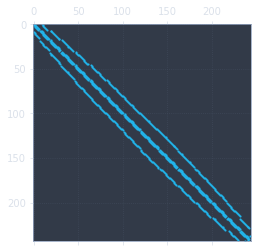

In [26]:
# look at the structure of the hamiltonian
spy(Hbenne,ms=1)

In [28]:
# solve sparse eigen problem, look for states near the lower edge of the spectrum i.e. around -4
va,ve=sl.eigsh(Hbenne,30,sigma=-4)

In [29]:
# these are the eigenvalues we found 
va

array([-3.92926721, -3.8430791 , -3.80255655, -3.71947702, -3.68323622,
       -3.60746479, -3.56636579, -3.52652011, -3.44943074, -3.38734515,
       -3.35194562, -3.34587095, -3.24880607, -3.18925653, -3.1562821 ,
       -3.1433686 , -3.04087621, -3.0334332 , -2.97082015, -2.93687007,
       -2.89883931, -2.81926392, -2.7920088 , -2.74389589, -2.71043142,
       -2.68924445, -2.63546968, -2.55162634, -2.5475842 , -2.48125306])

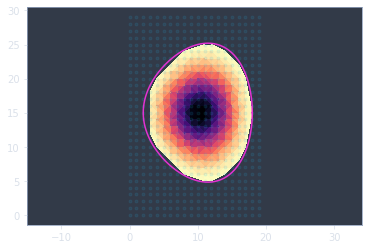

In [30]:
# look at the first eigenvalue found
plot(x,y,'.',alpha=0.1)
plot(px,py)

tripcolor(x[benne_van],y[benne_van],ve[:,0]**2,cmap='magma_r')
axis('equal');

In [16]:
# make a widget to explore wavefunctions
@interact(i=(0,len(va)-1))
def play(i=0):
    tripcolor(x[benne_van],y[benne_van],ve[:,i]**2,cmap='magma_r') # density assotiated to i-th  wavefunction
    plot(x[~benne_van],y[~benne_van],'ws') # blanket out area not calculated
    plot(px,py) # draw edge of the potato
    axis('equal')
    axis('off')

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

# Efficient way of finding certain elements of the Green's function

In [31]:
L=1000 # define rectangular sample 
W=200

In [32]:
# define some helper matrices to be used in hamiltonian construction
idL=ss.eye(L)
idW=ss.eye(W)

odL=ss.diags(ones(L-1),1,(L,L))
odW=ss.diags(ones(W-1),1,(W,W))

In [33]:
# define slices of the hamiltonian
h0=-odW-odW.T
h1=-idW

In [34]:
# build hamiltonian corresponding to big square
H=(ss.kron(idL,h0)+ss.kron(odL,h1)+ss.kron(odL,h1).T)

In [35]:
Z=0.1+0.0001j                # energy at which we evaluate the Green's function
Gi=(Z*ss.eye(H.shape[0])-H)  # The matrix we invert
solver=sl.factorized(Gi.tocsc())

In [36]:
first=ss.vstack((idW,zeros(((L-1)*W,W))))
last=ss.vstack((zeros(((L-1)*W,W)),idW))

In [37]:
Ge=solver(first.toarray())[list(range(W))+list(range((L-1)*W,L*W)),:]
Gv=solver(last.toarray())[list(range(W))+list(range((L-1)*W,L*W)),:]

In [38]:
G_surf=hstack((Ge,Gv))

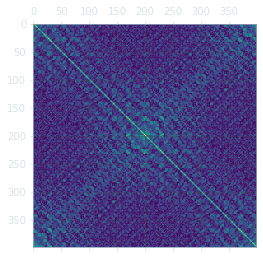

In [39]:
matshow(abs(G_surf))